In [499]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
from os import listdir
import sys
import pandas as pd
import random
import itertools

from collections import OrderedDict, Counter
import argparse
import gzip
import json
import chardet
import traceback
from time import time
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [498]:
from styles import *

In [282]:
def normalize_count(d):
    d = Counter(d)
    total = np.sum(list(d.values()))
    return { k: (v / total) for k, v in d.items() }

In [311]:
features_dir = '../features'
results_dir = '../results'
corpuses = [ 'webtables', 'plotly', 'manyeyes', 'opendata', 'viznet']
aggregate_field_features_base_file_name = '{}_aggregate_single_field_features.csv'
single_field_features_base_file_name = '{}_single_field_features.csv'

aggregate_feature_names_to_use = [
    'exists-agg-num',
    'length-agg-max',
    'general_type_is_c-agg-num',
    'general_type_is_t-agg-num',
    'general_type_is_q-agg-num',
    'is_normal_5-agg-num',
    'is_sorted-agg-num',
    'is_normal_5-agg-percentage',
    'is_sorted-agg-percentage',
]

single_field_feature_names_to_use = [
    'length',
    'entropy',
    'general_type_is_c',
    'general_type_is_t',
    'general_type_is_q',
    'sortedness',
    'entropy',
    'normality_statistic',
    'normality_p',
    'is_normal_5',
    'list_entropy',
    'is_sorted',
    'num_unique_elements'
    
]

distributions = [
    'norm',
    'lognorm',
    'expon',
    'powerlaw',
    'uniform',
    'chi2'
]

for dist_name in distributions:
    single_field_feature_names_to_use.extend([
        '{}_ks_statistic'.format(dist_name),
        '{}_ks_p'.format(dist_name)
    ])

In [ ]:
nrows_agg = 100000
nrows_single = 1000000
aggregate_feature_dfs_by_corpus = OrderedDict()
single_field_feature_dfs_by_corpus = OrderedDict()

for corpus in corpuses:
    print('Corpus:', corpus)
    aggregate_features_df = pd.read_csv(
        join(features_dir, aggregate_field_features_base_file_name.format(corpus)),
        usecols=[ 'dataset_id' ] + aggregate_feature_names_to_use,
        nrows=nrows_agg
    )
    print('Aggregate:', aggregate_features_df.shape)
    single_field_features_df = pd.read_csv(
        join(features_dir, single_field_features_base_file_name.format(corpus)),
        usecols=[ 'dataset_id', 'field_id' ] + single_field_feature_names_to_use,
        nrows=nrows_single
    )
    
    aggregate_feature_dfs_by_corpus[corpus] = aggregate_features_df
    single_field_feature_dfs_by_corpus[corpus] = single_field_features_df
    print('Single field:', single_field_features_df.shape)
    print('-----------------------')

In [551]:
combined_dataset = pd.concat([ df for df in aggregate_feature_dfs_by_corpus.values() ])
aggregate_feature_dfs_by_corpus['viznet'] = combined_dataset

In [552]:
combined_single_field_dataset = pd.concat([ df for df in single_field_feature_dfs_by_corpus.values() ])
single_field_feature_dfs_by_corpus['viznet'] = combined_single_field_dataset

## Column Distribution

In [503]:
for corpus in corpuses:
    df = aggregate_feature_dfs_by_corpus[corpus]
    x = df['exists-agg-num']
    desc = x.describe()
    print(corpus, desc['mean'], desc['50%'])

webtables 4.97703 4.0
plotly 19.500994871794873 3.0
manyeyes 5.56938 2.0
opendata 12.56184 2.0
viznet 10.596659119496856 3.0


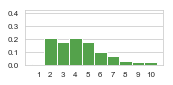

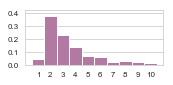

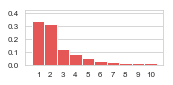

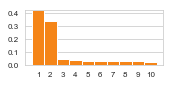

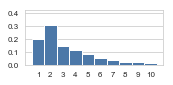

In [694]:
max_columns = 11
bin_labels = np.arange(1, max_columns + 1, step=1) 
bins = bin_labels - 0.5

n_cols_by_corpus = {}
for corpus in corpuses:
    x = aggregate_feature_dfs_by_corpus[corpus]['exists-agg-num']
    n_cols = x[x < np.percentile(x, 99.9)]
    n_cols_by_corpus[corpus] = n_cols

distplot_params = {
    'bins': bins,
    'hist': True,
    'kde': False,
    'norm_hist': True,
    'hist_kws': { 'alpha': 1}
}

textwidth = 7.48
figurewidth = 2.45  #  . (textwidth / 3)
figureheight = (figurewidth / 2)

for (label, data) in n_cols_by_corpus.items():
    fig = plt.figure(figsize=(figurewidth, figureheight))
    ax = sns.distplot(
        data,
        color=colors[label],
        label=label,
        # hist_kws=dict(alpha=1),
        **distplot_params
    )  #, hist=False, rug=True)
    ax.legend().set_visible(False)
    ax.grid(False)
    ax.yaxis.grid(True)
    plt.xlim([0, 11])
    plt.ylim([0, .42])
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ])
    plt.xlabel(False)
    ax.xaxis.label.set_visible(False)
    # plt.xlabel('Number of Columns')
    # plt.legend(False)
    
    file_name = 'column_distribution_{}'.format(label)
    plt.tight_layout()
    plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
    plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', pad_inches=0.0, bbox_inches='tight')
    plt.show()

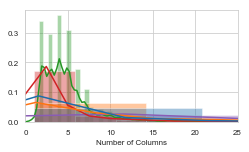

In [415]:
for corpus in corpuses:
    ax = sns.distplot(
        n_cols_by_corpus[corpus],
        color=colors[corpus],
        label=formatted_names[corpus],
    )
    ax.set_xlim([0, 25])
    ax.set_xlabel('Number of Columns')

## Row Distribution

In [313]:
for corpus in corpuses:
    df = aggregate_feature_dfs_by_corpus[corpus]
    x = df['length-agg-max']
    desc = x.describe()
    print(corpus, desc['mean'], desc['50%'])

webtables 14.21792 5.0
plotly 5911.647715451709 50.0
manyeyes 963.9397333975749 19.0
opendata 14252.532028397565 70.0
viznet 5258.101140130588 17.0


webtables
plotly
manyeyes
opendata
viznet


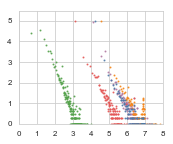

In [693]:
field = 'length-agg-max'

from scipy.optimize import curve_fit

xlim_max = 0
ylim_max = 0

textwidth = 7.48
figurewidth = 2.45  #  . (textwidth / 3)
figureheight = (figurewidth / 2)
fig, ax = plt.subplots(figsize=(figurewidth, figurewidth / 1.2))
# fig = plt.figure(figsize=(figurewidth, figureheight))
    
for (corpus, data) in aggregate_feature_dfs_by_corpus.items():

    print(corpus)
    x = data[field] * 2.5
    
    if corpus == 'viznet':
        # Correct for 4x as many samples
        x = list(x)
        random.shuffle(x)
        x = pd.Series(list(x)[:int((len(x) / 4))])
    x.dropna(inplace=True)

    counts, bin_edges = np.histogram(
        np.array(x),
        bins=1000,  # 'auto'
    )

    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    x = bin_centers
    y = counts

    ax.scatter(
        x,
        y,
        c=colors[corpus],
        label=formatted_names[corpus],
        alpha=0.8,
        s=1
    )
    if np.max(bin_centers) > xlim_max:
        xlim_max = np.max(bin_centers)
    if np.max(counts) > ylim_max:
        ylim_max = np.max(counts)

    
    ax.set_xlim([1, 50000000])
    ax.set_ylim([1, 10**5.5])
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xticks([1, 10, 100, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8])
    ax.set_yticks([1, 10, 100, 10**3, 10**4, 10**5])
    
    ax.set_xticks([1, 10, 100, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8])
    ax.set_yticks([1, 10, 100, 10**3, 10**4, 10**5])
    
    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_yticklabels([0, 1, 2, 3, 4, 5 ])
    
    ax.xaxis.label.set_visible(False)
    
file_name = 'row_distribution_all'
plt.tight_layout()
plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', pad_inches=0.0, bbox_inches='tight')
plt.show()

## Type Distribution

In [ ]:
type_fields = ['general_type_is_c', 'general_type_is_q', 'general_type_is_t']

type_field_abbrev_to_name = OrderedDict([
    ('c', 'Categorical'),
    ('q', 'Quantitative'),
    ('t', 'Temporal')
])

data_types = [ 'Categorical', 'Quantitative', 'Temporal']

type_counts_by_dataset = { corpus: Counter({ d: 0 for d in data_types}) for corpus in corpuses }

for corpus in corpuses:
    df = single_field_feature_dfs_by_corpus[corpus]
    for i, row in df.iterrows():
        if i % 100000 == 0: print(corpus, i)
        for type_field in type_fields:
            if row[type_field]:
                type_field_abbrev = type_field.split('_')[-1]
                type_field_name = type_field_abbrev_to_name[type_field_abbrev]
                type_counts_by_dataset[corpus][type_field_name] += 1

webtables Categorical 575807
webtables Quantitative 355617
webtables Temporal 68576
plotly Categorical 172532
plotly Quantitative 753248
plotly Temporal 72242
manyeyes Categorical 513562
manyeyes Quantitative 459314
manyeyes Temporal 24750
opendata Categorical 762250
opendata Quantitative 211100
opendata Temporal 22343
viznet Categorical 2024151
viznet Quantitative 1779279
viznet Temporal 187911
        corpus     Data Type   percent
0   Web Tables   Categorical  0.575807
1   Web Tables  Quantitative  0.355617
2   Web Tables      Temporal  0.068576
3       Plotly   Categorical  0.172874
4       Plotly  Quantitative  0.754741
5       Plotly      Temporal  0.072385
6    Many Eyes   Categorical  0.514784
7    Many Eyes  Quantitative  0.460407
8    Many Eyes      Temporal  0.024809
9    Open Data   Categorical  0.765547
10   Open Data  Quantitative  0.212013
11   Open Data      Temporal  0.022440
12      VizNet   Categorical  0.507136
13      VizNet  Quantitative  0.445785
14      VizNet  

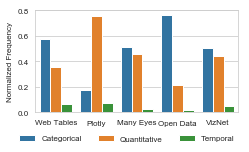

In [336]:
data_for_type_bar_chart = []
for corpus in corpuses:
    d = type_counts_by_dataset[corpus]
    
    total_count = sum(d.values())
    for t, count in d.items():
        print(corpus, t, count)
        percent = count / total_count
        data_for_type_bar_chart.append(OrderedDict([
            ('corpus', formatted_names[corpus]),
            ('Data Type', t),
            ('percent', percent)
        ]))
df = pd.DataFrame(data_for_type_bar_chart)

ax = sns.barplot(
    x='corpus',
    y='percent',
    hue='Data Type',
    # hue_order=data_type_orders,
    data=df
)
ax.legend(
    ncol=3,
    loc=9,
    bbox_to_anchor=(0.45, -0.15),
    frameon=False
)
ax.set(ylabel="Normalized Frequency")
ax.set(xlabel="")

file_name = 'type_distribution_{}'.format(nrows_single)
plt.tight_layout()
plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', bbox_inches='tight')
plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', bbox_inches='tight')

plt.show()

No handles with labels found to put in legend.


webtables Categorical 575807
webtables Quantitative 355617
webtables Temporal 68576
plotly Categorical 172532
plotly Quantitative 753248
plotly Temporal 72242
manyeyes Categorical 513562
manyeyes Quantitative 459314
manyeyes Temporal 24750
opendata Categorical 762250
opendata Quantitative 211100
opendata Temporal 22343
viznet Categorical 2024151
viznet Quantitative 1779279
viznet Temporal 187911
        corpus     Data Type   percent
0   Web Tables   Categorical  0.575807
1   Web Tables  Quantitative  0.355617
2   Web Tables      Temporal  0.068576
3       Plotly   Categorical  0.172874
4       Plotly  Quantitative  0.754741
5       Plotly      Temporal  0.072385
6    Many Eyes   Categorical  0.514784
7    Many Eyes  Quantitative  0.460407
8    Many Eyes      Temporal  0.024809
9    Open Data   Categorical  0.765547
10   Open Data  Quantitative  0.212013
11   Open Data      Temporal  0.022440
12      VizNet   Categorical  0.507136
13      VizNet  Quantitative  0.445785
14      VizNet  

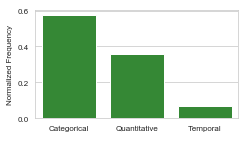

No handles with labels found to put in legend.


   corpus     Data Type   percent
3  Plotly   Categorical  0.172874
4  Plotly  Quantitative  0.754741
5  Plotly      Temporal  0.072385


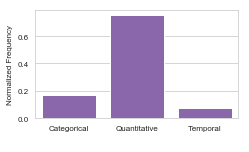

No handles with labels found to put in legend.


      corpus     Data Type   percent
6  Many Eyes   Categorical  0.514784
7  Many Eyes  Quantitative  0.460407
8  Many Eyes      Temporal  0.024809


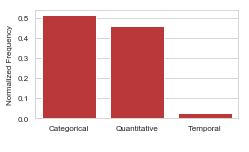

No handles with labels found to put in legend.


       corpus     Data Type   percent
9   Open Data   Categorical  0.765547
10  Open Data  Quantitative  0.212013
11  Open Data      Temporal  0.022440


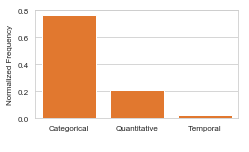

No handles with labels found to put in legend.


    corpus     Data Type   percent
12  VizNet   Categorical  0.507136
13  VizNet  Quantitative  0.445785
14  VizNet      Temporal  0.047080


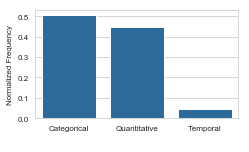

In [440]:
## Split apart by corpus

data_for_type_bar_chart = []
for corpus in corpuses:
    d = type_counts_by_dataset[corpus]
    
    total_count = sum(d.values())
    for t, count in d.items():
        print(corpus, t, count)
        percent = count / total_count
        data_for_type_bar_chart.append(OrderedDict([
            ('corpus', formatted_names[corpus]),
            ('Data Type', t),
            ('percent', percent)
        ]))
df = pd.DataFrame(data_for_type_bar_chart)

for corpus in corpuses:
    fig, ax = plt.subplots(figsize=(3.5, 3.5/ 1.618))
    corpus_type_dist_df = df[df['corpus'] == formatted_names[corpus]]
    print(corpus_type_dist_df)
    ax = sns.barplot(
        x='Data Type',
        y='percent',
        # hue='Data Type',
        # hue_order=data_type_orders,
        data=corpus_type_dist_df,
        color=colors[corpus]
    )
    ax.legend(
        ncol=3,
        loc=9,
        bbox_to_anchor=(0.45, -0.15),
        frameon=False
    )
    ax.set(ylabel="Normalized Frequency")
    ax.set(xlabel="")

    file_name = 'type_distribution_{}'.format(nrows_single)
    plt.tight_layout()
    plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', bbox_inches='tight')
    plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', bbox_inches='tight')

    plt.show()

## Statistical Distributions

### Quantitative

In [ ]:
dist_counts_by_dataset = { corpus: Counter() for corpus in corpuses }
alpha = 0.05 / 6  # Null hypo (== drawn from same parent dist) rejection threshold

# Take the max if multiple are greater than 0.05

dist_p_value_fields = [ '{}_ks_p'.format(dist_name) for dist_name in distributions ]

for df_name, df in single_field_feature_dfs_by_corpus.items():
    df_only_q = df[df['general_type_is_q']]

    for i, row in df_only_q.iterrows():
        if (i % 10000) == 0: print(i)
        dist_p_values = dict([( v, float(row[v])) for v in dist_p_value_fields])
        
        filtered_dist_p_values = { k: v for (k, v) in dist_p_values.items() if (v > alpha)}
        if not len(filtered_dist_p_values):
            dist_counts_by_dataset[df_name]['undetermined'] += 1
            continue
        
        max_p_dist = max(filtered_dist_p_values, key=lambda k: filtered_dist_p_values[k])
        dist_counts_by_dataset[df_name][max_p_dist.split('_')[0]] += 1

       corpus Distribution   percent    color
0  Web Tables          L-N  0.175127  #54a24b
1  Web Tables          Exp  0.103814  #54a24b
2  Web Tables         Norm  0.377164  #54a24b
3  Web Tables          Pow  0.115990  #54a24b
4  Web Tables          Und  0.157852  #54a24b
5  Web Tables        Chi-2  0.023393  #54a24b
6  Web Tables         Unif  0.046660  #54a24b


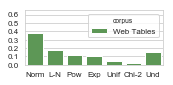

    corpus Distribution   percent    color
7   Plotly          Und  0.351348  #b279a2
8   Plotly          L-N  0.203852  #b279a2
9   Plotly         Norm  0.151452  #b279a2
10  Plotly          Pow  0.100734  #b279a2
11  Plotly        Chi-2  0.043628  #b279a2
12  Plotly         Unif  0.073364  #b279a2
13  Plotly          Exp  0.075622  #b279a2


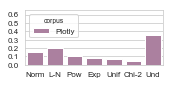

       corpus Distribution   percent    color
14  Many Eyes          Exp  0.089932  #e45756
15  Many Eyes          Und  0.305656  #e45756
16  Many Eyes          L-N  0.187351  #e45756
17  Many Eyes         Norm  0.241473  #e45756
18  Many Eyes          Pow  0.097252  #e45756
19  Many Eyes        Chi-2  0.053353  #e45756
20  Many Eyes         Unif  0.024983  #e45756


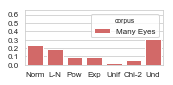

       corpus Distribution   percent    color
21  Open Data          L-N  0.107020  #f58518
22  Open Data          Und  0.575031  #f58518
23  Open Data         Norm  0.125936  #f58518
24  Open Data          Exp  0.065789  #f58518
25  Open Data         Unif  0.034751  #f58518
26  Open Data          Pow  0.055429  #f58518
27  Open Data        Chi-2  0.036045  #f58518


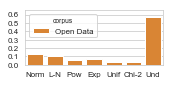

In [743]:
data_for_dist_bar_chart = []
for corpus in corpuses:
    d = dist_counts_by_dataset[corpus]
    
    total_count = sum(d.values())
    for dist, count in d.items():
        percent = count / total_count
        data_for_dist_bar_chart.append(OrderedDict([
            ('corpus', formatted_names[corpus]),
            ('Distribution', dist),
            ('percent', percent)
        ]))

df = pd.DataFrame(data_for_dist_bar_chart)

dist_to_formatted_name = {
    'norm': 'Normal',
    'chi2': 'Chi-squared',
    'powerlaw': 'Power Law',
    'uniform': 'Uniform',
    'expon': 'Exponential',
    'lognorm': 'Log-normal',
    'undetermined': 'Undetermined'
}

dist_to_formatted_name = {
    'norm': 'Normal',
    'chi2': 'Chi-2',
    'powerlaw': 'Power',
    'uniform': 'Unif',
    'expon': 'Expo',
    'lognorm': 'Log-norm',
    'undetermined': 'Undet'
}

dist_to_formatted_name = {
    'norm': 'Norm',
    'chi2': 'Chi-2',
    'powerlaw': 'Pow',
    'uniform': 'Unif',
    'expon': 'Exp',
    'lognorm': 'L-N',
    'undetermined': 'Und'
}

df['Distribution'] = df['Distribution'].map(dist_to_formatted_name)

data_dist_orders = [
    'Norm',
    'L-N',
    'Pow',
    'Exp',
    'Unif',
    'Chi-2',
    'Und'
]

colors_dict = {
    'brown': '#9d755d',
    'pink': '#ff9da6',
    'green': '#54a24b',
    'blue': '#4c78a8',
    'orange': '#f58518',
    'red': '#e45756',
    'purple': '#b279a2',
    'teal': '#72b7b2'
}

colors = {
    'manyeyes': colors_dict['red'],
    'plotly': colors_dict['purple'],
    'viznet': colors_dict['blue'],
    'webtables': colors_dict['green'],
    'opendata': colors_dict['orange']
}

formatted_name_colors = { formatted_names[c]: colors[c] for c in corpuses}

for corpus in corpuses:

    fig, ax = plt.subplots(figsize=(figurewidth, figureheight))

    df_with_fits = df[df['corpus'] == formatted_names[corpus]]
    df_with_fits['color'] = df_with_fits['corpus'].map(formatted_name_colors)
    
    ax = sns.barplot(
        x='Distribution',
        y='percent',
        order=data_dist_orders,
        hue='corpus',
        palette=formatted_name_colors,
        # hue_order=data_type_orders,
        # palette=sns.color_palette(colors.values()),
        data=df_with_fits
    )

    ax.set_xticklabels(data_dist_orders)
    ax.set(ylabel="")
    ax.set(xlabel="")
    ax.set_ylim([0, 0.65])
    ax.set_yticks([ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ])
    # ax.set_xticks([])
    ax.xaxis.label.set_visible(False)

    file_name = 'statistical_distribution_{}'.format(corpus)
    plt.tight_layout()
    plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
    plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', pad_inches=0.0, bbox_inches='tight')
    plt.show()

       corpus Distribution   percent    color
0  Web Tables          L-N  0.175127  #54a24b
1  Web Tables          Exp  0.103814  #54a24b
2  Web Tables         Norm  0.377164  #54a24b
3  Web Tables          Pow  0.115990  #54a24b
4  Web Tables          Und  0.157852  #54a24b
5  Web Tables        Chi-2  0.023393  #54a24b
6  Web Tables         Unif  0.046660  #54a24b


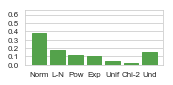

    corpus Distribution   percent    color
7   Plotly          Und  0.351348  #b279a2
8   Plotly          L-N  0.203852  #b279a2
9   Plotly         Norm  0.151452  #b279a2
10  Plotly          Pow  0.100734  #b279a2
11  Plotly        Chi-2  0.043628  #b279a2
12  Plotly         Unif  0.073364  #b279a2
13  Plotly          Exp  0.075622  #b279a2


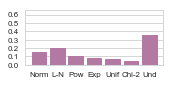

       corpus Distribution   percent    color
14  Many Eyes          Exp  0.089932  #e45756
15  Many Eyes          Und  0.305656  #e45756
16  Many Eyes          L-N  0.187351  #e45756
17  Many Eyes         Norm  0.241473  #e45756
18  Many Eyes          Pow  0.097252  #e45756
19  Many Eyes        Chi-2  0.053353  #e45756
20  Many Eyes         Unif  0.024983  #e45756


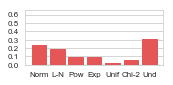

       corpus Distribution   percent    color
21  Open Data          L-N  0.107020  #f58518
22  Open Data          Und  0.575031  #f58518
23  Open Data         Norm  0.125936  #f58518
24  Open Data          Exp  0.065789  #f58518
25  Open Data         Unif  0.034751  #f58518
26  Open Data          Pow  0.055429  #f58518
27  Open Data        Chi-2  0.036045  #f58518


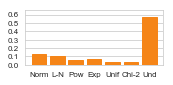

In [753]:
data_for_dist_bar_chart = []
percent_by_corpus_and_dist = { c: {} for c in corpuses }
for corpus in corpuses:
    d = dist_counts_by_dataset[corpus]
    
    total_count = sum(d.values())
    for dist, count in d.items():
        percent = count / total_count
        data_for_dist_bar_chart.append(OrderedDict([
            ('corpus', formatted_names[corpus]),
            ('Distribution', dist),
            ('percent', percent)
        ]))
        
        percent_by_corpus_and_dist[corpus][dist_to_formatted_name[dist]] = percent

df = pd.DataFrame(data_for_dist_bar_chart)

dist_to_formatted_name = {
    'norm': 'Normal',
    'chi2': 'Chi-squared',
    'powerlaw': 'Power Law',
    'uniform': 'Uniform',
    'expon': 'Exponential',
    'lognorm': 'Log-normal',
    'undetermined': 'Undetermined'
}

dist_to_formatted_name = {
    'norm': 'Normal',
    'chi2': 'Chi-2',
    'powerlaw': 'Power',
    'uniform': 'Unif',
    'expon': 'Expo',
    'lognorm': 'Log-norm',
    'undetermined': 'Undet'
}

dist_to_formatted_name = {
    'norm': 'Norm',
    'chi2': 'Chi-2',
    'powerlaw': 'Pow',
    'uniform': 'Unif',
    'expon': 'Exp',
    'lognorm': 'L-N',
    'undetermined': 'Und'
}

df['Distribution'] = df['Distribution'].map(dist_to_formatted_name)

data_dist_orders = [
    'Norm',
    'L-N',
    'Pow',
    'Exp',
    'Unif',
    'Chi-2',
    'Und'
]

colors_dict = {
    'brown': '#9d755d',
    'pink': '#ff9da6',
    'green': '#54a24b',
    'blue': '#4c78a8',
    'orange': '#f58518',
    'red': '#e45756',
    'purple': '#b279a2',
    'teal': '#72b7b2'
}

colors = {
    'manyeyes': colors_dict['red'],
    'plotly': colors_dict['purple'],
    'viznet': colors_dict['blue'],
    'webtables': colors_dict['green'],
    'opendata': colors_dict['orange']
}

formatted_name_colors = { formatted_names[c]: colors[c] for c in corpuses}

for corpus in corpuses:
    fig, ax = plt.subplots(figsize=(figurewidth, figureheight))

    df_with_fits = df[df['corpus'] == formatted_names[corpus]]
    df_with_fits['color'] = df_with_fits['corpus'].map(formatted_name_colors)
    
    
    print(df_with_fits)
    bars = plt.bar(
        data_dist_orders,
        [ percent_by_corpus_and_dist[corpus][d] for d in data_dist_orders ]
        # df_with_fits['Distribution'],
        # df_with_fits['percent'],
        # order=data_dist_orders,
        # hue='corpus',
        # palette=formatted_name_colors,
        # hue_order=data_type_orders,
        # palette=sns.color_palette(colors.values()),
        # data=df_with_fits
    )
    
    for b in bars:
        b.set_color(colors[corpus])

    ax.grid(False)
    ax.grid(True, which='major', axis='y')
    # ax.set_xticklabels(data_dist_orders)
#     ax.set(ylabel="")
#     ax.set(xlabel="")
    ax.set_ylim([0, 0.65])
    ax.set_yticks([ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ])
    # ax.set_xticks([])
    ax.xaxis.label.set_visible(False)

    file_name = 'statistical_distribution_{}'.format(corpus)
    plt.tight_layout()
    plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
    plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', pad_inches=0.0, bbox_inches='tight')
    plt.show()


### Categorical

webtables 0.9483787503586559
webtables 1.0
1.0000000000000009
plotly 0.6803824316200449
plotly 0.979613309799034
1.000000000000001
manyeyes 0.8126631125413759
manyeyes 0.9911594714322187
1.0000000000000009
opendata 0.49866632981682624
opendata 0.41671334543624977
1.0000000000000182


No handles with labels found to put in legend.


viznet 0.7880930531205531
viznet 0.9942505366120983
1.0000000000000182


<Figure size 252x155.748 with 0 Axes>

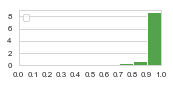

No handles with labels found to put in legend.


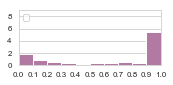

No handles with labels found to put in legend.


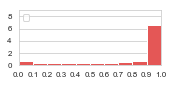

No handles with labels found to put in legend.


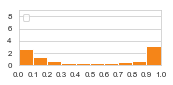

No handles with labels found to put in legend.


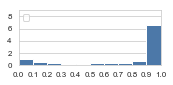

In [684]:
# Split by corpus

field_name = 'list_entropy'
plt.figure()

entropy_by_corpus = {}
for corpus in corpuses:
    df = single_field_feature_dfs_by_corpus[corpus]
    df = df[df['general_type_is_c']]
    
    entropy = df[field_name]
    max_entropy = np.log(df['num_unique_elements'])
    normalized_entropy = entropy / max_entropy
    
    entropy_by_corpus[corpus] = [ c for c in normalized_entropy if not pd.isnull(c) ]
    print(corpus, np.nanmean(normalized_entropy))
    print(corpus, np.nanmedian(normalized_entropy))
    print(np.max(normalized_entropy))
    
# bin_values, bin_labels = pd.Series(entropy_by_corpus[''])
    
# entropy_by_corpus = { c: [] for c in corpuses }
# for corpus, df in single_field_feature_dfs_by_corpus.items():
#     df_only_c = df[df['general_type_is_c'] == True]
#     x = df[field_name].dropna()
#     x = x[x <= 10]
    
#     ax = sns.distplot(x, label=corpus, norm_hist=True, kde=False, bins=10)  #, hist=False, rug=True))
#     ax.set(xlabel=corpus)
#     ax.set_xlim(0, 10)
    
#     plt.show()
textwidth = 7.48
figurewidth = 2.45  #  . (textwidth / 3)
figureheight = (figurewidth / 2)
    
for corpus in corpuses:
    
    fig, ax = plt.subplots(figsize=(figurewidth, figureheight))
    entropy = entropy_by_corpus[corpus]
    ax = sns.distplot(
        entropy,
        color=colors[corpus],
        bins=10,
        norm_hist=True,
        kde=False,
        hist_kws=dict(alpha=1)
    )

    plt.grid(False)
    plt.grid(True, which='major', axis='y')

    plt.xticks([ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([ 0, 2, 4, 6, 8 ])
    plt.ylim(0, 9)
    plt.xlim(0, 1)
    plt.legend(loc='upper left')

    file_name = 'entropy_distribution_{}'.format(corpus)
    plt.tight_layout()
    plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
    plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf',pad_inches=0.0, bbox_inches='tight')

    plt.show()

webtables 0.9483787503586559
webtables 1.0
1.0000000000000009
plotly 0.6803824316200449
plotly 0.979613309799034
1.000000000000001
manyeyes 0.8126631125413759
manyeyes 0.9911594714322187
1.0000000000000009
opendata 0.49866632981682624
opendata 0.41671334543624977
1.0000000000000182
viznet 0.7880930531205531
viznet 0.9942505366120983
1.0000000000000182


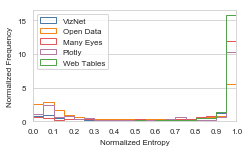

In [682]:
field_name = 'list_entropy'
plt.figure()

entropy_by_corpus = {}
for corpus in corpuses:
    df = single_field_feature_dfs_by_corpus[corpus]
    df = df[df['general_type_is_c']]
    
    entropy = df[field_name]
    max_entropy = np.log(df['num_unique_elements'])
    normalized_entropy = entropy / max_entropy
    
    entropy_by_corpus[corpus] = [ c for c in normalized_entropy if not pd.isnull(c) ]
    print(corpus, np.nanmean(normalized_entropy))
    print(corpus, np.nanmedian(normalized_entropy))
    print(np.max(normalized_entropy))
    
ax = plt.hist(
    [ entropy_by_corpus[c] for c in corpuses ],
    color=[ colors[c] for c in corpuses],
    label=[ formatted_names[c] for c in corpuses ],
    # alpha=0.5,
    # rwidth=0.1,
    normed=1,
    histtype='step', # 'bar', 
    lw=1,
    bins=20
)

plt.grid(False)
plt.grid(True, which='major', axis='y')

plt.xlabel('Normalized Entropy')
plt.ylabel('Normalized Frequency')
plt.xticks([ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xlim([0, max_columns])
# plt.yscale('log')
plt.xlim(0, 1)
plt.legend(loc='upper left')


# Separate into three plots
# Test distribution

file_name = 'entropy_distribution'.format(nrows_agg)
plt.tight_layout()
plt.savefig(join(results_dir, '{}.svg'.format(file_name)), format='svg', pad_inches=0.0, bbox_inches='tight')
plt.savefig(join(results_dir, '{}.pdf'.format(file_name)), format='pdf', pad_inches=0.0, bbox_inches='tight')

plt.show()

## Taxonomy

In [646]:
def stringify_type_count_dict(d):
    # s = 'c={};q={};t={}'.format(d['c'], d['q'], d['t'])
    s = '{} {} {}'.format(d['c'], d['q'], d['t'])
    return s

types = ['c', 't', 'q']
max_columns = 5

total_num_combinations = 0

all_type_combinations = {}
for num_columns in range(1, max_columns + 1):
    type_combinations = list(itertools.combinations_with_replacement(types, num_columns))
    print(type_combinations)
    all_type_combinations[num_columns] = [ Counter(x) for x in type_combinations ]
    total_num_combinations += len(type_combinations)

print('Total number of combinations:', total_num_combinations)

[('c',), ('t',), ('q',)]
[('c', 'c'), ('c', 't'), ('c', 'q'), ('t', 't'), ('t', 'q'), ('q', 'q')]
[('c', 'c', 'c'), ('c', 'c', 't'), ('c', 'c', 'q'), ('c', 't', 't'), ('c', 't', 'q'), ('c', 'q', 'q'), ('t', 't', 't'), ('t', 't', 'q'), ('t', 'q', 'q'), ('q', 'q', 'q')]
[('c', 'c', 'c', 'c'), ('c', 'c', 'c', 't'), ('c', 'c', 'c', 'q'), ('c', 'c', 't', 't'), ('c', 'c', 't', 'q'), ('c', 'c', 'q', 'q'), ('c', 't', 't', 't'), ('c', 't', 't', 'q'), ('c', 't', 'q', 'q'), ('c', 'q', 'q', 'q'), ('t', 't', 't', 't'), ('t', 't', 't', 'q'), ('t', 't', 'q', 'q'), ('t', 'q', 'q', 'q'), ('q', 'q', 'q', 'q')]
[('c', 'c', 'c', 'c', 'c'), ('c', 'c', 'c', 'c', 't'), ('c', 'c', 'c', 'c', 'q'), ('c', 'c', 'c', 't', 't'), ('c', 'c', 'c', 't', 'q'), ('c', 'c', 'c', 'q', 'q'), ('c', 'c', 't', 't', 't'), ('c', 'c', 't', 't', 'q'), ('c', 'c', 't', 'q', 'q'), ('c', 'c', 'q', 'q', 'q'), ('c', 't', 't', 't', 't'), ('c', 't', 't', 't', 'q'), ('c', 't', 't', 'q', 'q'), ('c', 't', 'q', 'q', 'q'), ('c', 'q', 'q', 'q', 

In [358]:
count_by_number_of_columns_and_types = { c: dict() for c in range(1, max_columns + 1) }

for num_columns, type_combinations in all_type_combinations.items():
    df = combined_dataset
    df_filtered_by_num_columns = df[df['exists-agg-num'] == num_columns]
    print('Total for', num_columns, 'columns:', len(df_filtered_by_num_columns))
    
    for type_combination in type_combinations:
        key = stringify_type_count_dict(type_combination)
        print(key)
        df_filtered_by_num_columns_and_type = df[
            (df['exists-agg-num'] == num_columns) &
            (df['general_type_is_c-agg-num'] == type_combination['c']) &
            (df['general_type_is_t-agg-num'] == type_combination['t']) &
            (df['general_type_is_q-agg-num'] == type_combination['q'])
        ]
        print(', '.join("{!s}={!r}".format(key,val) for (key,val) in type_combination.items()), ':',
              len(df_filtered_by_num_columns_and_type))
        
        count_by_number_of_columns_and_types[num_columns][key] = len(df_filtered_by_num_columns_and_type)
    print('---')

Total for 1 columns: 41117
1 0 0
c=1 : 38518
0 0 1
t=1 : 278
0 1 0
q=1 : 1829
---
Total for 2 columns: 48484
2 0 0
c=2 : 12028
1 0 1
c=1, t=1 : 1102
1 1 0
c=1, q=1 : 15445
0 0 2
t=2 : 110
0 1 1
t=1, q=1 : 12999
0 2 0
q=2 : 6437
---
Total for 3 columns: 24829
3 0 0
c=3 : 4855
2 0 1
c=2, t=1 : 1475
2 1 0
c=2, q=1 : 3986
1 0 2
c=1, t=2 : 192
1 1 1
c=1, t=1, q=1 : 1178
1 2 0
c=1, q=2 : 7072
0 0 3
t=3 : 11
0 1 2
t=2, q=1 : 86
0 2 1
t=1, q=2 : 3241
0 3 0
q=3 : 2680
---
Total for 4 columns: 20007
4 0 0
c=4 : 4491
3 0 1
c=3, t=1 : 2358
3 1 0
c=3, q=1 : 1503
2 0 2
c=2, t=2 : 355
2 1 1
c=2, t=1, q=1 : 851
2 2 0
c=2, q=2 : 2499
1 0 3
c=1, t=3 : 18
1 1 2
c=1, t=2, q=1 : 81
1 2 1
c=1, t=1, q=2 : 445
1 3 0
c=1, q=3 : 3531
0 0 4
t=4 : 10
0 1 3
t=3, q=1 : 13
0 2 2
t=2, q=2 : 486
0 3 1
t=1, q=3 : 1115
0 4 0
q=4 : 2234
---
Total for 5 columns: 14808
5 0 0
c=5 : 1588
4 0 1
c=4, t=1 : 803
4 1 0
c=4, q=1 : 1269
3 0 2
c=3, t=2 : 866
3 1 1
c=3, t=1, q=1 : 852
3 2 0
c=3, q=2 : 959
2 0 3
c=2, t=3 : 26
2 1 2
c=

count               float64
type_composition     object
dtype: object


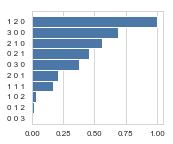

In [755]:
# Separate

from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter

def tick_label_formatter(k):
    return '  '.join(k.split(';'))

nrow = 5
ncol = 1

fig, ax = plt.subplots(figsize=(figurewidth, figurewidth / 1.2))
for num_columns, v in count_by_number_of_columns_and_types.items():   
    if num_columns != 3:
        continue
    # ax = plt.subplot(gs[num_columns - 1,0])
    
    # fig = plt.figure(figsize=(3.5, 5 * (3.5 / 1.618))) 
    # print(v)
    df = pd.DataFrame.from_dict(v, orient='index', columns=[ 'count' ])
    df['type_composition'] = df.index


    total = np.max(df['count'])
    
    plt.grid(False)
    plt.grid(True, which='major', axis='x')
    
    df['count'] = df['count'] / total
    df.columns = [ tick_label_formatter(k) for k in list(df.columns)]
    df['count'] = df['count'].astype(float)

    df = df.sort_values(['count'], ascending=False)
    # ax.set_title('{} Column Datasets'.format(num_columns))
        
    # ax.set_xlim(0, 1.0)
    ax.set_ylim(9.5,-1)

    print(df.dtypes)
#     ax.barh(
#         df['type_composition'],
#         df['count'],
#         height=1

#     )
    ax.barh(
        df['type_composition'],
        df['count'],
        1,
        # orient='h',
        color=colors['viznet']
        # width=3,
    )

plt.savefig('../results/taxonomy_3.svg'.format(num_columns), format='svg', pad_inches=0.0, bbox_inches='tight')
plt.savefig('../results/taxonomy_3.pdf'.format(num_columns), format='pdf', pad_inches=0.0, bbox_inches='tight')
plt.show()    

In [ ]:

from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter

def tick_label_formatter(k):
    return '  '.join(k.split(';'))

fig = plt.figure(figsize=(3.5, 5 * (3.5 / 1.618))) 
nrow = 5
ncol = 1
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.001, right=0.999) 
fig.suptitle('Normalized Frequency of Type Distributions by Number of Columns', y=0.93)
for num_columns, v in count_by_number_of_columns_and_types.items():    
    ax = plt.subplot(gs[num_columns - 1,0])

    print(v)
    df = pd.DataFrame.from_dict(v, orient='index', columns=[ 'count' ])
    df['type_composition'] = df.index

    # print(df)
    # print(df)
    # df = pd.DataFrame(v, index=[0]) # for type_combination, count in v.items():
    # print(df)
    # df = df.sort_values(by=0, axis=1, ascending=False)
    
    
    total = np.max(df['count'])
    df['count'] = df['count'] / total
    df.columns = [ tick_label_formatter(k) for k in list(df.columns)]
    df['count'] = df['count'].astype(float)

    if num_columns == 1:
        a = plt.annotate(
            '$\mathregular{C}$ $\mathregular{Q}$ $\mathregular{T}$',
            xy=(-0.11, -0.3),
            xycoords='data',
            annotation_clip=False,
        )
        a.set_family('Helvetica')
        a.set_weight(500)
        a.set_fontsize(8)
    ax.set_ylabel('{} Column Datasets'.format(num_columns))
    if num_columns < 5:
        ax.set_xticklabels([])
        
    ax.set_xlim(0, 1.0)

    ax.barh(
        df['type_composition'],
        df['count'],
        height=1
        
    )

plt.savefig('../results/taxonomy_equal_width_{}.svg'.format(num_columns), format='svg', bbox_inches='tight')
plt.savefig('../results/taxonomy_equal_width_{}.pdf'.format(num_columns), format='pdf', bbox_inches='tight')
plt.show()